In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import RMSprop
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)

Seed set to 0


## Loading data

In [2]:
unrate = pd.read_csv('UNRATE.csv')
unrate

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2
920,2024-09-01,4.1


## Processing data

In [3]:
unrate['DATE'] = pd.to_datetime(unrate['DATE'])
unrate.set_index('DATE', inplace=True)
unrate

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2024-06-01,4.1
2024-07-01,4.3
2024-08-01,4.2


In [4]:
scaler = MinMaxScaler()
unrate['UNRATE'] = scaler.fit_transform(unrate[['UNRATE']])

In [5]:
unrate

,UNRATE
DATE,
1948-01-01,0.073171
1948-02-01,0.105691
1948-03-01,0.121951
1948-04-01,0.113821
1948-05-01,0.081301
...,...
2024-06-01,0.130081
2024-07-01,0.146341
2024-08-01,0.138211


In [6]:
nber_recessions = [
    ('1948-12-01', '1949-10-31'),
    ('1953-08-01', '1954-05-31'),
    ('1957-09-01', '1958-04-30'),
    ('1960-05-01', '1961-02-28'),
    ('1970-01-01', '1970-11-30'),
    ('1973-12-01', '1975-03-31'),
    ('1980-02-01', '1980-07-31'),
    ('1981-08-01', '1982-11-30'),
    ('1990-07-01', '1991-03-31'),  
    ('2008-01-01', '2009-06-30'),
    ('2020-03-01', '2020-04-30')
]
nber_recessions = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in nber_recessions]

In [7]:
nber_recessions

[(Timestamp('1948-12-01 00:00:00'), Timestamp('1949-10-31 00:00:00')),
 (Timestamp('1953-08-01 00:00:00'), Timestamp('1954-05-31 00:00:00')),
 (Timestamp('1957-09-01 00:00:00'), Timestamp('1958-04-30 00:00:00')),
 (Timestamp('1960-05-01 00:00:00'), Timestamp('1961-02-28 00:00:00')),
 (Timestamp('1970-01-01 00:00:00'), Timestamp('1970-11-30 00:00:00')),
 (Timestamp('1973-12-01 00:00:00'), Timestamp('1975-03-31 00:00:00')),
 (Timestamp('1980-02-01 00:00:00'), Timestamp('1980-07-31 00:00:00')),
 (Timestamp('1981-08-01 00:00:00'), Timestamp('1982-11-30 00:00:00')),
 (Timestamp('1990-07-01 00:00:00'), Timestamp('1991-03-31 00:00:00')),
 (Timestamp('2008-01-01 00:00:00'), Timestamp('2009-06-30 00:00:00')),
 (Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-30 00:00:00'))]

labeling recessions

In [8]:
def label_recession(row, recessions):
    for start, end in recessions:
        if start <= row.name <= end:
            return 1
    return 0

unrate['RECESSION'] = unrate.apply(lambda row: label_recession(row, nber_recessions), axis=1)
unrate

,UNRATE,RECESSION
DATE,,
1948-01-01,0.073171,0
1948-02-01,0.105691,0
1948-03-01,0.121951,0
1948-04-01,0.113821,0
1948-05-01,0.081301,0
...,...,...
2024-06-01,0.130081,0
2024-07-01,0.146341,0
2024-08-01,0.138211,0


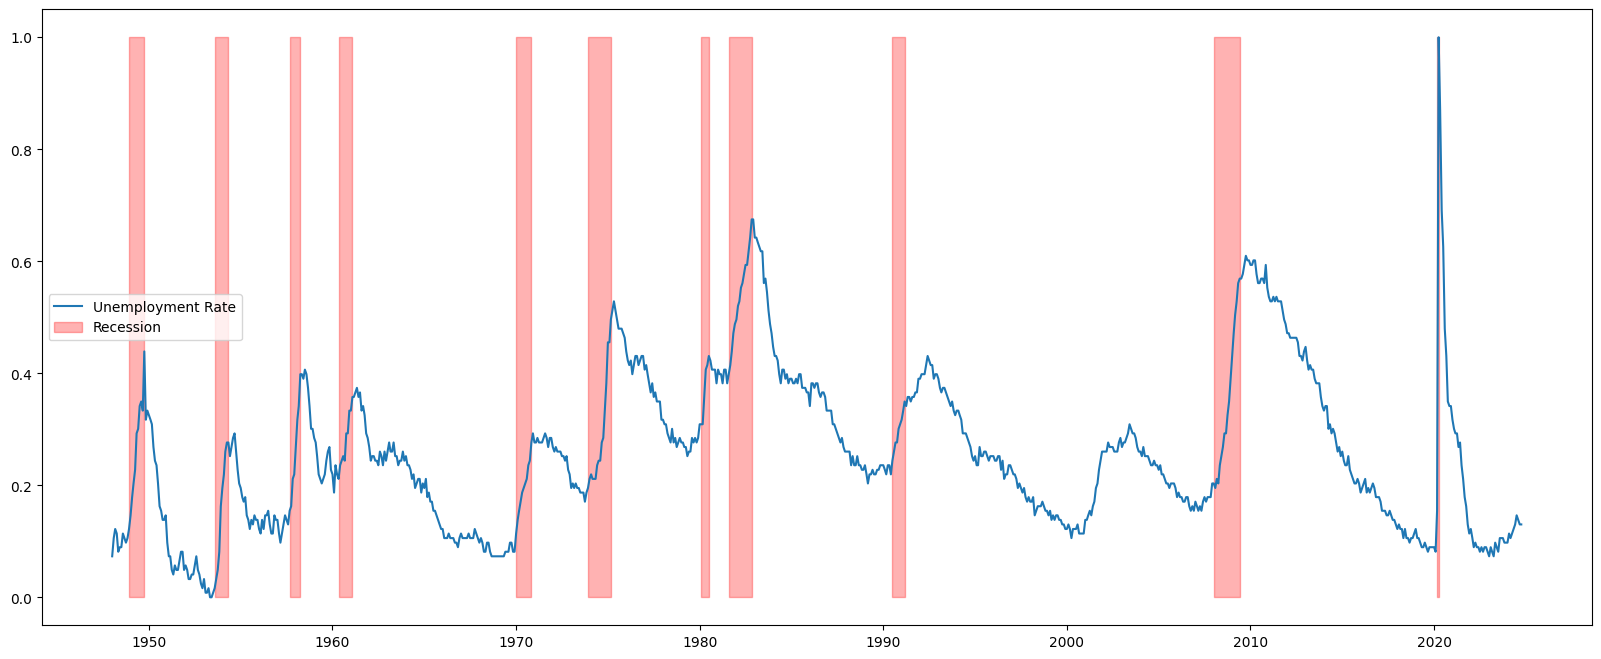

In [9]:
fig, ax = subplots(figsize=(20, 8))
ax.plot(unrate.index, unrate['UNRATE'], label='Unemployment Rate')
ax.fill_between(unrate.index, 0, 1, where=unrate['RECESSION'] == 1, 
                 color='red', alpha=0.3, label='Recession')
ax.legend()

Splitting data into train and test

In [10]:
split_index = int(len(unrate) * 0.8) 
unrate_train = unrate.iloc[:split_index]
unrate_test = unrate.iloc[split_index:]

## Creating sequences for LSTM

In [11]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data['UNRATE'].iloc[i:i+sequence_length].values)
        y.append(data['RECESSION'].iloc[i+sequence_length])
    return np.array(X), np.array(y)

In [12]:
sequence_length = 12 # 12 months
X_train, y_train = create_sequences(unrate_train, sequence_length)
X_test, y_test = create_sequences(unrate_test, sequence_length)

## Building model

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) 
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
class RecessionPredictor(nn.Module):
    def __init__(self):
        super(RecessionPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.dense = nn.Linear(50, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        output = self.dense(lstm_out)
        return output

In [15]:
train_dataset = TensorDataset(torch.Tensor(X_train).unsqueeze(-1), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test).unsqueeze(-1), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
model = RecessionPredictor()

In [17]:
summary(model, input_size=X_train.shape, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RecessionPredictor                       [725, 12, 1]              [725, 1]                  --
├─LSTM: 1-1                              [725, 12, 1]              [725, 12, 50]             31,000
├─Linear: 1-2                            [725, 50]                 [725, 1]                  51
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 269.74
Input size (MB): 0.03
Forward/backward pass size (MB): 3.49
Params size (MB): 0.12
Estimated Total Size (MB): 3.64

In [18]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training loop

In [35]:
def train_improved_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR over time
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.squeeze(-1)
            outputs = model(X_batch)
            loss = F.binary_cross_entropy_with_logits(outputs.squeeze(), y_batch, pos_weight=torch.tensor(2.0))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        
        scheduler.step()
        
        
        model.eval()
        y_preds, y_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.squeeze(-1)
                outputs = model(X_batch)
                preds = torch.sigmoid(outputs).squeeze() > 0.25  
                y_preds.extend(preds.cpu().numpy())
                y_actuals.extend(y_batch.cpu().numpy())
        
        
        
        precision = precision_score(y_actuals, y_preds, zero_division=0)
        recall = recall_score(y_actuals, y_preds)
        f1 = f1_score(y_actuals, y_preds)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    accuracy = accuracy_score(y_actuals, y_preds)
    print(f"Accuracy: {accuracy:.4f}")

In [36]:
train_improved_model(model, train_loader, test_loader, 50, 0.001)

Epoch 1/50, Loss: 10.0349, Precision: 0.0123, Recall: 0.5000, F1: 0.0241
Epoch 2/50, Loss: 9.2163, Precision: 0.0345, Recall: 0.5000, F1: 0.0645
Epoch 3/50, Loss: 8.8016, Precision: 0.0500, Recall: 1.0000, F1: 0.0952
Epoch 4/50, Loss: 9.2270, Precision: 0.0455, Recall: 1.0000, F1: 0.0870
Epoch 5/50, Loss: 9.2363, Precision: 0.0303, Recall: 0.5000, F1: 0.0571
Epoch 6/50, Loss: 8.5522, Precision: 0.0370, Recall: 0.5000, F1: 0.0690
Epoch 7/50, Loss: 8.4618, Precision: 0.0435, Recall: 1.0000, F1: 0.0833
Epoch 8/50, Loss: 9.1629, Precision: 0.0308, Recall: 1.0000, F1: 0.0597
Epoch 9/50, Loss: 9.4925, Precision: 0.0645, Recall: 1.0000, F1: 0.1212
Epoch 10/50, Loss: 9.1121, Precision: 0.0312, Recall: 0.5000, F1: 0.0588
Epoch 11/50, Loss: 8.4456, Precision: 0.0172, Recall: 0.5000, F1: 0.0333
Epoch 12/50, Loss: 8.5245, Precision: 0.0244, Recall: 0.5000, F1: 0.0465
Epoch 13/50, Loss: 7.9304, Precision: 0.0286, Recall: 0.5000, F1: 0.0541
Epoch 14/50, Loss: 8.0399, Precision: 0.0000, Recall: 0.000

Changing the threshold to 0.5 increases the accuracy to around 91% but sets all other metrics to 0, and this loss in accuracy isn't justifiable in terms of the precision and recall increase.